<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/ML_AI24_HT7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 7: Fraud Detection Competition**

Добро пожаловать на финальное домашнее задание курса! Домашнее задание направлено на систематизацию всех знаний, полученных в процессе учебы.

В нём Вы потренируетесь применять навыки построения пайплайнов машинного обучения, приобретенные в курсе от точки разведочного анализа данных до построения и валидации моделей машинного обучения.

## **Задача**
**Вы будете решать задачу определения фрода:**

https://www.kaggle.com/competitions/fraud-detection-24

**Вам нужно будет:**
- в jupyter notebook провести исследование данных;
- в нём же построить модели и оценить их качество;
- отправить посылку на Kaggle.

Более подробное описание шагов - в ноутбуке ниже.

## **Оценивание и баллы**
- В EDA и во всей работе будут оцениваться полнота и **выводы**;
- При обучении моделей старайтесь обоснованно подходить к их выбору, избегая простого перебора;

**Максимальный балл** - 10 (+ бонусы за Kaggle, см. ниже).


Мягкий дедлайн (окончание соревнования на Kaggle): **15 марта 23:59**


# **Базовое решение и пример формирования файла под submission**


In [1]:
# # Создаем директорию data, если она не существует
# !mkdir -p data

# # Скачиваем файлы в директорию data
# !wget --no-check-certificate 'https://www.dropbox.com/s/5iuef7c9ljj84t6/train_transaction.csv?dl=0' -O data/train_transaction.csv
# !wget --no-check-certificate 'https://www.dropbox.com/s/cmy01z5fw7ohlmd/train_identity.csv?dl=0' -O data/train_identity.csv
# !wget --no-check-certificate 'https://www.dropbox.com/s/7thqkuxnwsa7njj/test_transaction.csv?dl=0' -O data/test_transaction.csv
# !wget --no-check-certificate 'https://www.dropbox.com/s/b40nvbb9e2usd5w/test_identity.csv?dl=0' -O data/test_identity.csv
# !wget --no-check-certificate 'https://www.dropbox.com/s/arkyoz0bel8z4d2/sample_submission.csv?dl=0' -O data/sample_submission.csv

In [2]:
# # Скачиваем файлы с Kaggle
# !pip install kaggle -q

# # Убедимся, что директория для API ключа Kaggle существует
# !mkdir -p ~/.kaggle

# # Создаем файл с API ключом Kaggle (замените на свой ключ)
# # Примечание: в реальном использовании лучше загрузить ключ из безопасного хранилища
# # !echo '{"username":"your_username","key":"your_api_key"}' > ~/.kaggle/kaggle.json
# # !chmod 600 ~/.kaggle/kaggle.json

# # Скачиваем файлы соревнования
# !kaggle competitions download -c fraud-detection-24 -p data
# !unzip -o data/fraud-detection-24.zip -d data


In [3]:
%pip install catboost -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
from catboost import CatBoostClassifier
import pandas as pd
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np


In [5]:
INPUT_DIR = 'data'

train_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'train_transaction.csv'))
train_identity = pd.read_csv(os.path.join(INPUT_DIR, 'train_identity.csv'))
test_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'test_transaction.csv'))
test_identity = pd.read_csv(os.path.join(INPUT_DIR, 'test_identity.csv'))
sample_submission = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))

df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')

df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')

In [6]:
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_train.shape, df_test.shape

((417559, 432), (172981, 431))

In [7]:
object_cols = []
for idx, col in tqdm(enumerate(df_train.columns.drop('isFraud'))):
    if df_train[col].dtype == 'O':
      object_cols.append(idx)

431it [00:00, 8178.36it/s]


In [8]:
df_train.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [9]:
X_train = df_train.drop('isFraud', axis=1)
X_train = X_train.fillna('')
y_train = df_train['isFraud'].values

# cb = CatBoostClassifier(iterations=3)
# cb.fit(X_train, y_train, object_cols, )

In [10]:
# predictions = cb.predict_proba(df_test.fillna(''))

In [11]:
# sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions[:, 0]})
# sub.head()

In [12]:
# Сохранение submission
# sub.to_csv('submission_baseline.csv', index=False)

In [13]:
# Отправка файла на соревнование
# !kaggle competitions submit -c fraud-detection-24 -f submission_baseline.csv -m "Базовая модель CatBoost"

### **Примечания:**

**1. Оценка качества и Submission File**
- Ответом является число от 0 до 1, метрикой качества - AUC-ROC.
- Структура Submission File:
 - для каждого значения *TransactionID* в тестовых данных вы должны предсказать **вероятность** для столбца *isFraud*.
 - в файле у вас должно быть две колонки: `TransactionID` и`isFraud`  **для каждой транзакции в датасете**.

**2. Объем данных**

Поскольку набор данных объемный, могут быть проблемы с переполнением памяти в Collab. Для решения проблемы можете использовать функцию из [этого ноутбука](https://colab.research.google.com/drive/18u75eyFGEoyeWJ_MbsLkcPa6gv2tNI8G#scrollTo=V2L1Nl5CTMMl), разобравшись, что она делает с данными.

# **Задание 1 (2 балла)**

Проведите EDA (разведочный анализ данных):
* проанализируйте признаки, их особенности и связь с целевой переменной
* проанализируйте целевую переменную
* оцените степень попарной взаимосвязи признаков, а также связи признаков и целевой переменной
* по результатам исследований сделайте необходимую обработку данных (удаление дублей, работа с пропусками, с категориальными столбцами (если они есть), работа с аномалиями, другие преобразования признаков)

Важно, что EDA всегда сопровождается выводами - не забудьте об этом.

## Анализ признаков

In [14]:
# ваш EDA здесь
print("\nИнформация о тренировочном наборе:")
df_train.info(verbose=False)


Информация о тренировочном наборе:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 432 entries, isFraud to DeviceInfo
dtypes: float64(399), int64(2), object(31)
memory usage: 1.3+ GB


#вывод
- В обучающей выборке 432 признака, включая целевую `isFraud`.
- dtypes: float64(399), int64(2), object(31)
- датасет занимает 1.3ГБ памяти, что много. Возможно типы данных неэффективно выбораны.

### Оптимизируем типы данных

In [15]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Использование памяти до оптимизации: {:.2f} MB'.format(start_mem))
    for col in tqdm(df.columns):
        if df[col].dtype not in ['object', 'category']: 

            is_NAN_or_INF = np.isfinite(df[col]).any() or df[col].isna().any()

            if np.all(np.abs(df[col].dropna() - df[col].dropna().round()) < 1e-15):
                rounded = df[col].dropna().round()
                rmin = rounded.min()
                rmax = rounded.max()

                if rmin >= 0:
                    if rmax < np.iinfo(np.uint8).max:
                        dtype_nullable = 'UInt8'
                        dtype_regular = np.uint8
                    elif rmax < np.iinfo(np.uint16).max:
                        dtype_nullable = 'UInt16'
                        dtype_regular = np.uint16
                    elif rmax < np.iinfo(np.uint32).max:
                        dtype_nullable = 'UInt32'
                        dtype_regular = np.uint32
                    else:
                        dtype_nullable = 'UInt64'
                        dtype_regular = np.uint64
                else:
                    if rmin > np.iinfo(np.int8).min and rmax < np.iinfo(np.int8).max:
                        dtype_nullable = 'Int8' 
                        dtype_regular = np.int8
                    elif rmin > np.iinfo(np.int16).min and rmax < np.iinfo(np.int16).max:
                        dtype_nullable = 'Int16'
                        dtype_regular = np.int16
                    elif rmin > np.iinfo(np.int32).min and rmax < np.iinfo(np.int32).max:
                        dtype_nullable = 'Int32'
                        dtype_regular = np.int32
                    elif rmin > np.iinfo(np.int64).min and rmax < np.iinfo(np.int64).max:
                        dtype_nullable = 'Int64'
                        dtype_regular = np.int64
                # Применяем выбранный тип данных
                try:
                    df[col] = df[col].astype(dtype_nullable) if is_NAN_or_INF else rounded.astype(dtype_regular)
                except:
                    print(f"Ошибка на {col}: {df[col].dtype} -> {dtype_nullable=}, {dtype_regular=}, {is_NAN_or_INF=}, {rmin=}, {rmax=}")
                    df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float32)
        else:  # тип object пытаемся преобразовать в category
            try:
                df[col] = df[col].astype('category')
            except:
                print(f"Ошибка на {col}: {df[col].dtype} -> 'category'")
    end_mem = df.memory_usage().sum() / 1024**2
    print('Использование памяти после оптимизации: {:.2f} MB'.format(end_mem))
    print('Уменьшение памяти на {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df


In [16]:
df_train = reduce_mem_usage(df_train)

Использование памяти до оптимизации: 1376.23 MB


100%|██████████| 432/432 [00:12<00:00, 34.30it/s]


Использование памяти после оптимизации: 416.20 MB
Уменьшение памяти на 69.8%


In [17]:
df_test = reduce_mem_usage(df_test)

Использование памяти до оптимизации: 568.81 MB


100%|██████████| 431/431 [00:05<00:00, 78.97it/s] 

Использование памяти после оптимизации: 174.10 MB
Уменьшение памяти на 69.4%


#вывод
| Занято памяти | До оптимизации | После оптимизации | Уменьшение |
|---------------|----------------|-------------------|------------|
| df_train      | 1376.23 MB     | 416.2 MB          | 69.8%      |
| df_test       |  568.81 MB     | 174.1 MB          | 69.4%      |

In [30]:
X_train = df_train.drop('isFraud', axis=1)
y_train = df_train['isFraud']
X_test = df_test.copy()

### Пропуски

In [19]:
missing_train = X_train.isnull().sum()
missing_train = missing_train.sort_values(ascending=False)
missing_train_prc = missing_train / len(df_train) * 100
missing_train[missing_train > 0].count()

371

In [20]:
missing_test = df_test.isnull().sum()
missing_test = missing_test.sort_values(ascending=False)
missing_test_prc = missing_test / len(df_test) * 100
missing_test.count()

431

#вывод  
Число признаков с пропусками
| df_train | df_test |
|----------|---------|
| 371      | 382     |

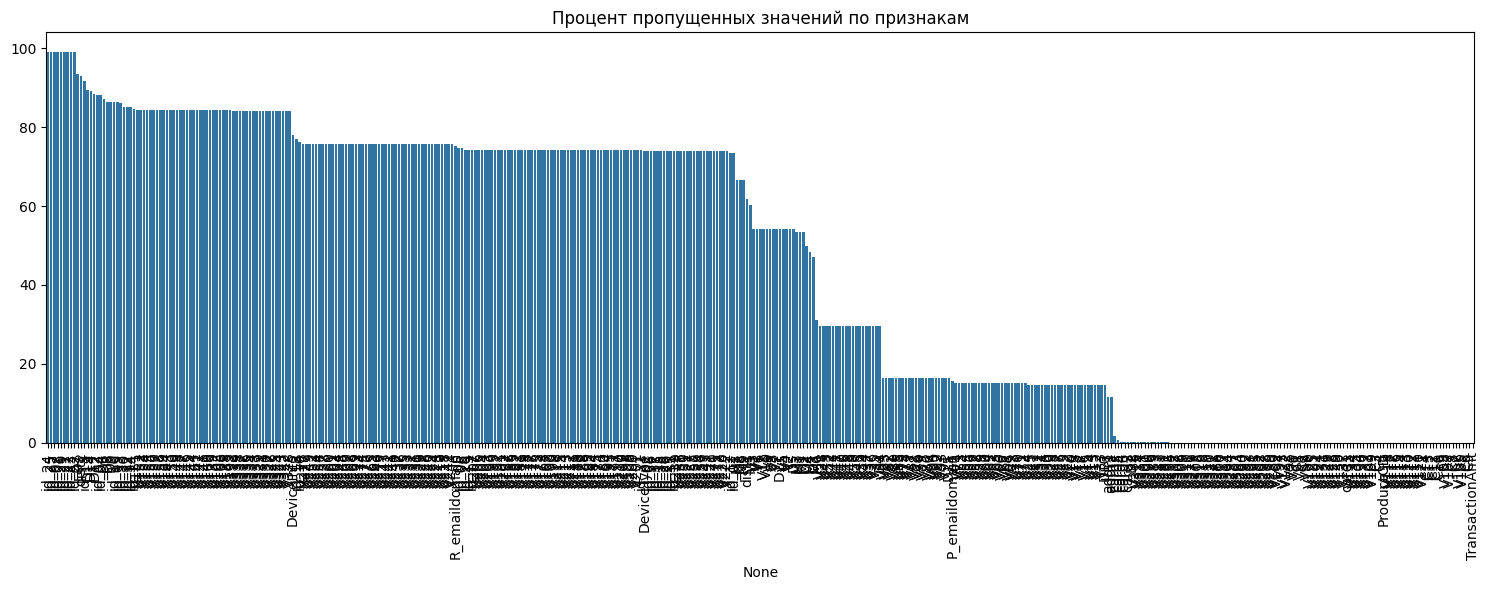

In [21]:
# Визуализация пропущенных значений
plt.figure(figsize=(15, 6))
sns.barplot(x=missing_train_prc.index, y=missing_train_prc.values)
plt.xticks(rotation=90)
plt.title('Процент пропущенных значений по признакам')
plt.tight_layout()
plt.show()

#вывод

Пока непонятно что делать с пропусками.
Видно, что есть группы признаков с одинаковыми уровнями пропусков, но их природа непонятна.

### Корреляция с целевой переменной

/Users/yukonoff/code/hse_ai_24/hse-ai24-ml/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/yukonoff/code/hse_ai_24/hse-ai24-ml/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


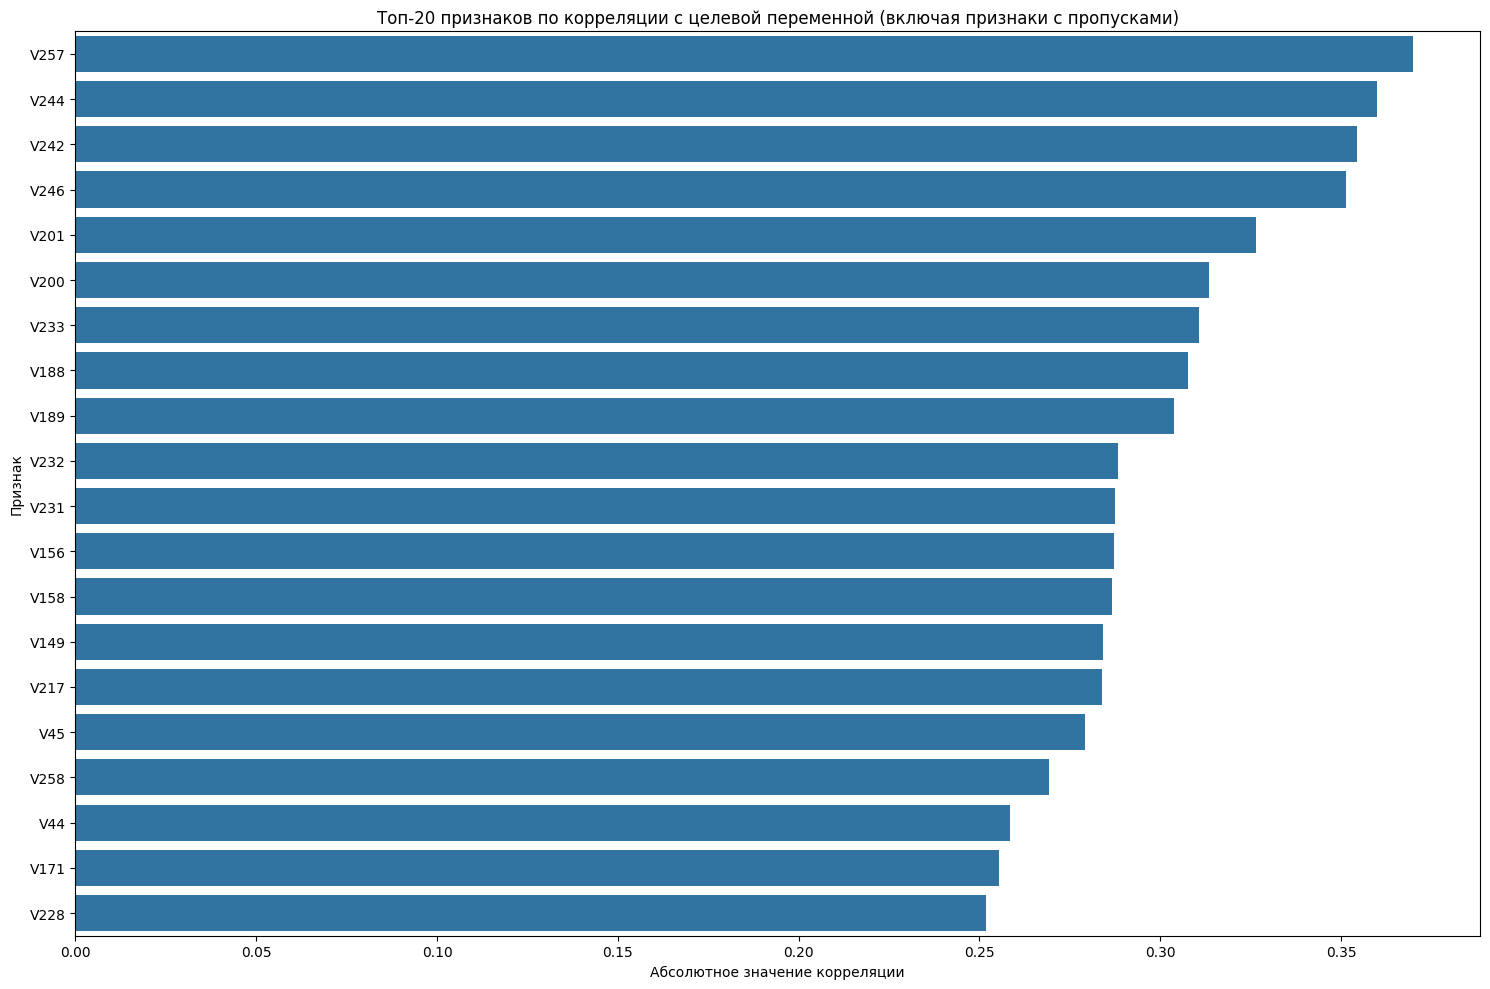

Топ-20 признаков с наибольшей корреляцией с целевой переменной:
V257    0.369941
V244    0.359899
V242    0.354488
V246    0.351318
V201    0.326478
V200    0.313537
V233    0.310822
V188    0.307764
V189    0.303891
V232    0.288307
V231    0.287530
V156    0.287339
V158    0.286551
V149    0.284183
V217    0.283805
V45     0.279115
V258    0.269148
V44     0.258370
V171    0.255530
V228    0.251739
dtype: float64

Процент пропусков в топ-20 признаках:
V257: 75.69%
V244: 75.69%
V242: 75.69%
V246: 75.69%
V201: 74.30%
V200: 74.30%
V233: 75.69%
V188: 74.30%
V189: 74.30%
V232: 75.69%
V231: 75.69%
V156: 84.31%
V158: 84.31%
V149: 84.31%
V217: 75.69%
V45: 29.48%
V258: 75.69%
V44: 29.48%
V171: 74.30%
V228: 75.69%


In [22]:
# Анализ корреляции признаков с целевой переменной
target_correlations = {}

# Получаем числовые признаки
numeric_features = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()

# Вычисляем корреляцию каждого числового признака с целевой переменной
for feature in numeric_features:
    # Для признаков с пропущенными значениями используем метод pairwise
    if X_train[feature].isnull().any():
        # Создаем временные копии для расчета корреляции
        feature_data = X_train[feature].copy()
        
        # Преобразуем y_train в Series, если это ndarray
        if isinstance(y_train, np.ndarray):
            y_train_series = pd.Series(y_train)
        else:
            y_train_series = y_train
        
        # Используем только непропущенные значения для расчета корреляции
        valid_indices = ~feature_data.isnull()
        if valid_indices.sum() > 0:  # Проверяем, что есть непустые значения
            correlation = abs(feature_data[valid_indices].corr(y_train_series[valid_indices]))
            target_correlations[feature] = correlation
    else:
        # Для признаков без пропусков используем стандартный метод
        if isinstance(y_train, np.ndarray):
            y_train_series = pd.Series(y_train)
        else:
            y_train_series = y_train
        
        target_correlations[feature] = abs(X_train[feature].corr(y_train_series))

del feature_data

# Сортируем признаки по убыванию корреляции
sorted_correlations = pd.Series(target_correlations).sort_values(ascending=False)

# Визуализируем топ-20 признаков с наибольшей корреляцией
plt.figure(figsize=(15, 10))
top_features = sorted_correlations.head(20)
sns.barplot(x=top_features.values, y=top_features.index)
plt.title('Топ-20 признаков по корреляции с целевой переменной (включая признаки с пропусками)')
plt.xlabel('Абсолютное значение корреляции')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

# Выводим топ-20 признаков с наибольшей корреляцией
print("Топ-20 признаков с наибольшей корреляцией с целевой переменной:")
print(top_features)

# Дополнительно: анализ процента пропусков для топ признаков
print("\nПроцент пропусков в топ-20 признаках:")
for feature in top_features.index:
    missing_pct = X_train[feature].isnull().mean() * 100
    print(f"{feature}: {missing_pct:.2f}%")


#вывод

Корреляции признаков с целевой переменной незначительные.

### Анализ целевой переменной

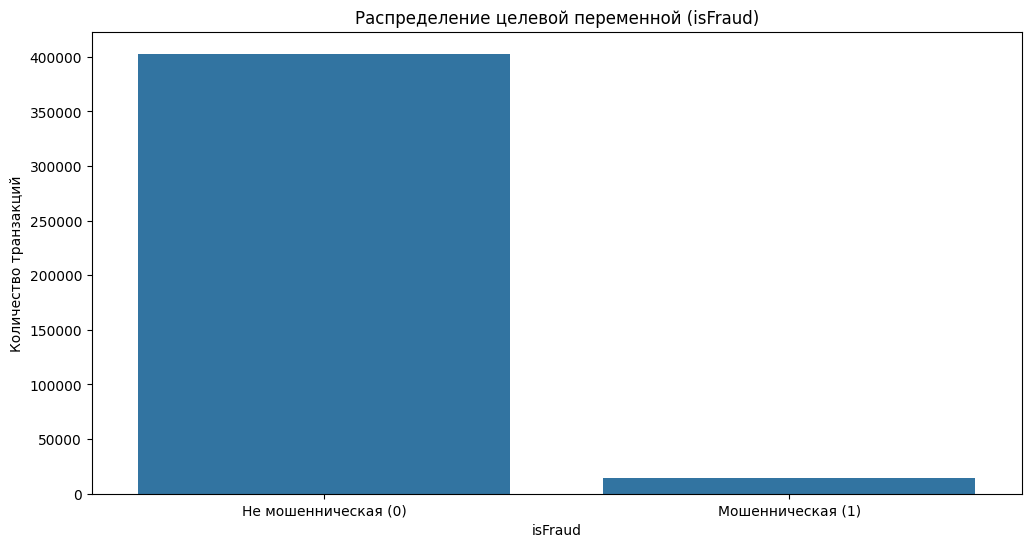

Процент мошеннических транзакций: 3.53%
Процент обычных транзакций: 96.47%
Соотношение обычных транзакций к мошенническим: 27.36:1


In [23]:
# Анализ распределения целевой переменной
plt.figure(figsize=(12, 6))
sns.countplot(x=y_train)
plt.title('Распределение целевой переменной (isFraud)')
plt.xlabel('isFraud')
plt.ylabel('Количество транзакций')
plt.xticks([0, 1], ['Не мошенническая (0)', 'Мошенническая (1)'])
plt.show()

# Вычисляем процентное соотношение классов
fraud_percentage = y_train.mean() * 100
non_fraud_percentage = 100 - fraud_percentage

print(f"Процент мошеннических транзакций: {fraud_percentage:.2f}%")
print(f"Процент обычных транзакций: {non_fraud_percentage:.2f}%")
print(f"Соотношение обычных транзакций к мошенническим: {non_fraud_percentage/fraud_percentage:.2f}:1")


#### Вывод

Из анализа целевой переменной можно сделать следующие выводы:

1. Сильный дисбаланс классов:
   - Мошеннические транзакции составляют значительное меньшинство
   - Это типично для задач обнаружения мошенничества

2. Последствия для моделирования:
   - Необходимо использовать метрики, устойчивые к дисбалансу классов (AUC-ROC, precision-recall)
   - Рассмотреть методы работы с несбалансированными данными:
     * Взвешивание классов (class_weights)
     * Сэмплирование (SMOTE, RandomUnderSampler)
     * Ансамблевые методы

3. Стратегия валидации:
   - Использовать стратифицированную кросс-валидацию для сохранения пропорций классов
   - Оценивать модель на различных метриках, не только accuracy

4. Бизнес-контекст:
   - Низкий процент мошеннических транзакций типичен для реальных данных
   - Ложные срабатывания могут быть дорогостоящими (блокировка легальных транзакций)
   - Пропуск мошеннических транзакций также несет финансовые потери

### Анализ попарных корреляций числовых признаков

Для анализа корреляций возьмем признаки с числом пропусков не более заданного порога. Для полного анализа установим уровень = 100%

Количество признаков с пропусками менее 100%: 400


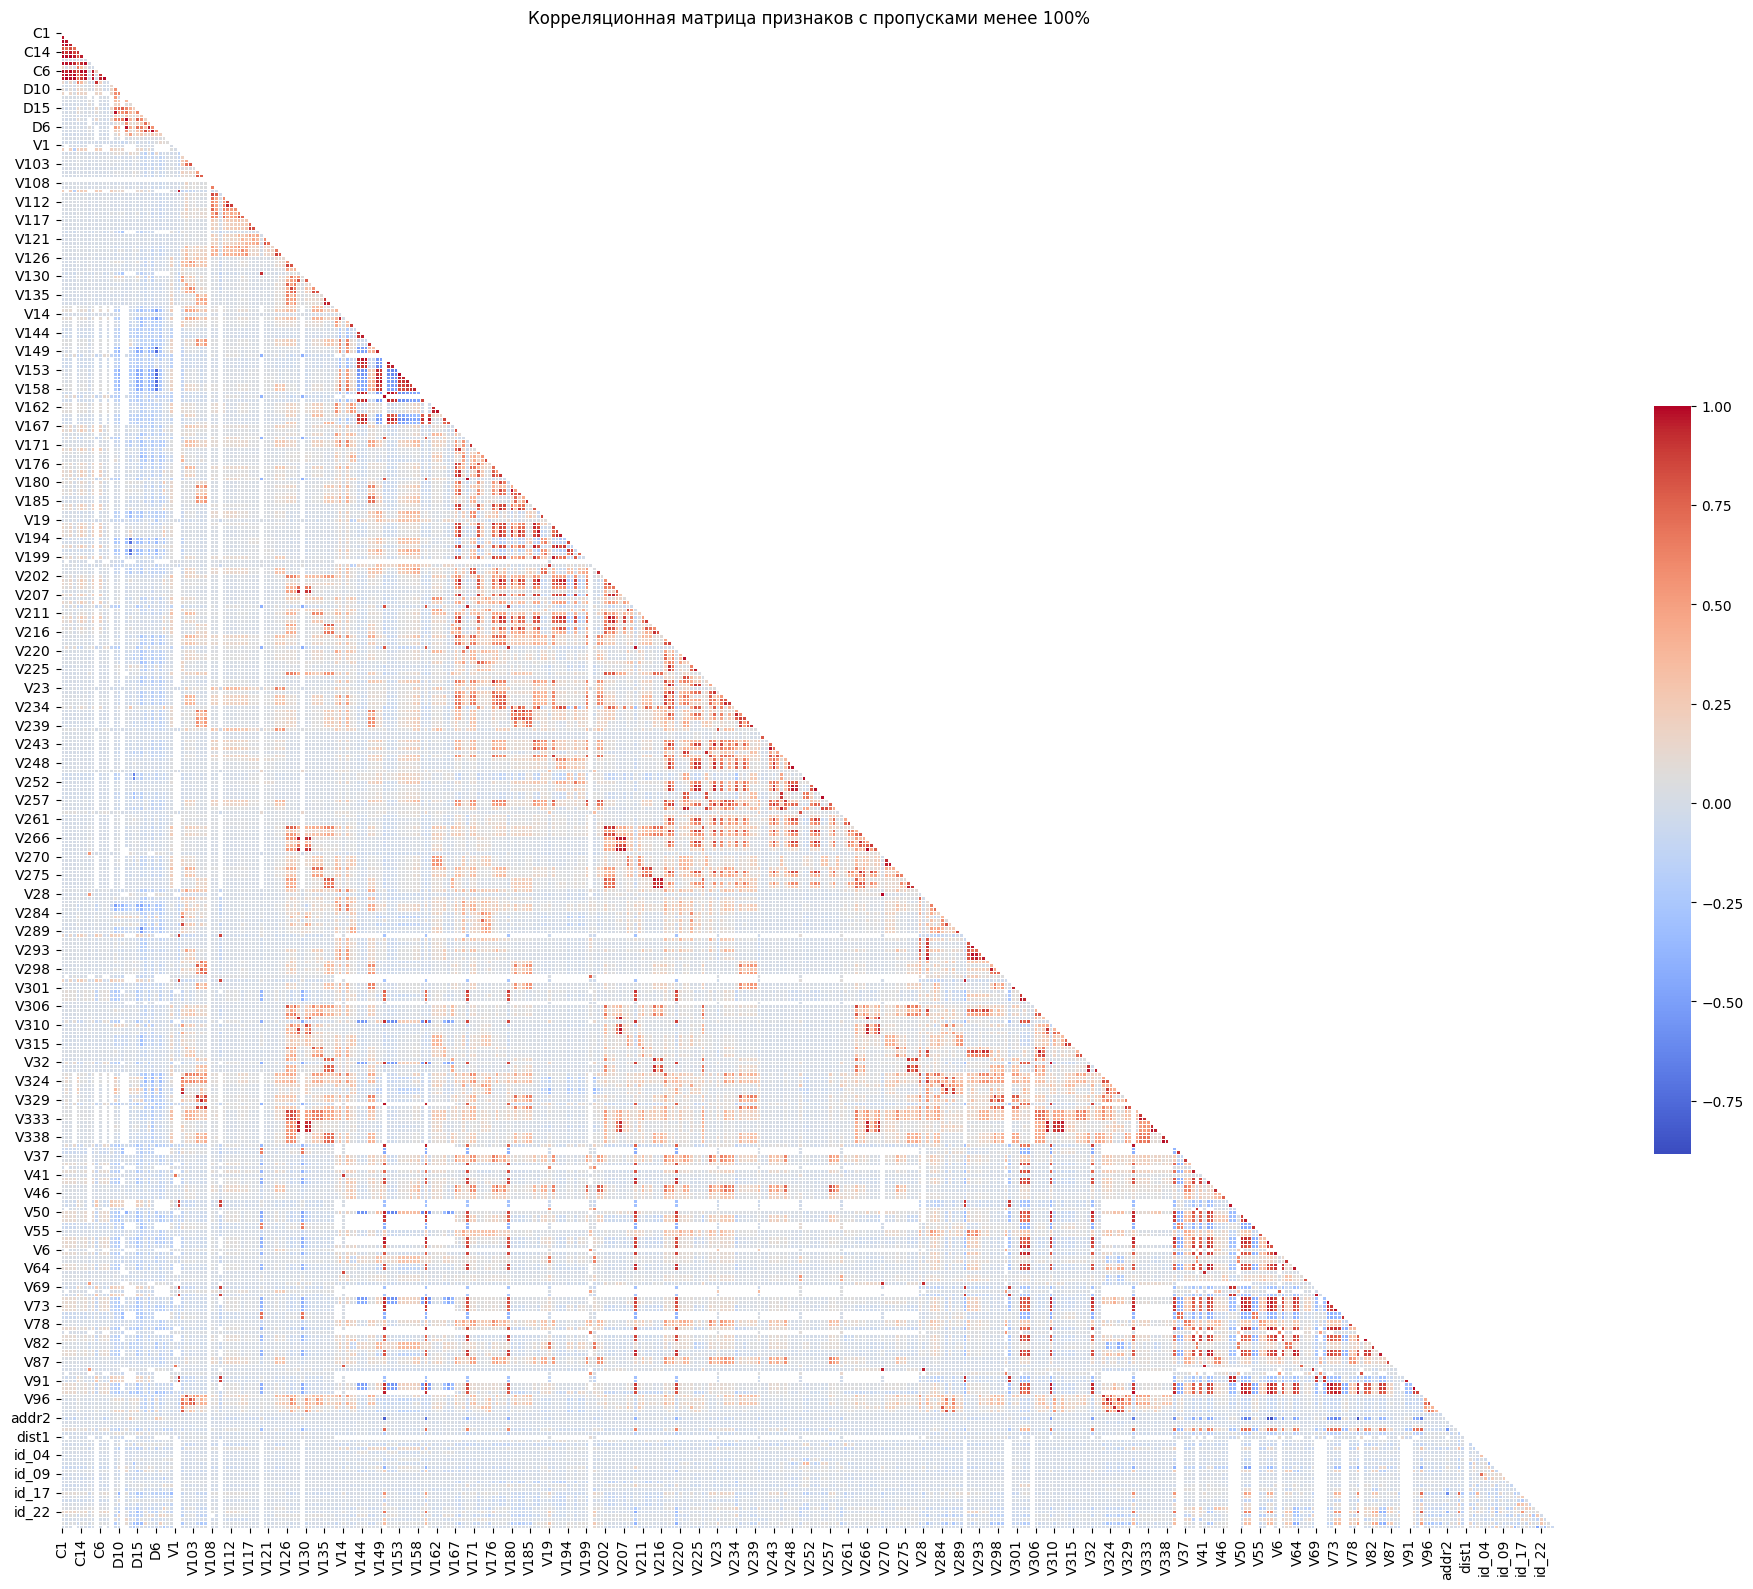

In [24]:
THRESHOLD_MISSING_PRC = 100
features_to_analyze = missing_train_prc[missing_train_prc <= THRESHOLD_MISSING_PRC].index.tolist()
features_to_analyze.sort()

# Создаем датафрейм только с нужными признаками
X_corr = X_train[features_to_analyze].select_dtypes(exclude=['object', 'category']).copy()

# Вычисляем корреляционную матрицу
correlation_matrix = X_corr.corr()
print(f"Количество признаков с пропусками менее {THRESHOLD_MISSING_PRC}%: {X_corr.shape[1]}")

# Визуализация корреляционной матрицы
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=False, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title(f'Корреляционная матрица признаков с пропусками менее {THRESHOLD_MISSING_PRC}%')
plt.tight_layout()
plt.show()


Матрица не очень удобна для визуальной интерпретации, т.к. слишком большая.  
Исследуем попарные корреляции признаков.

#### Выбор порогового значения попарной корреляции

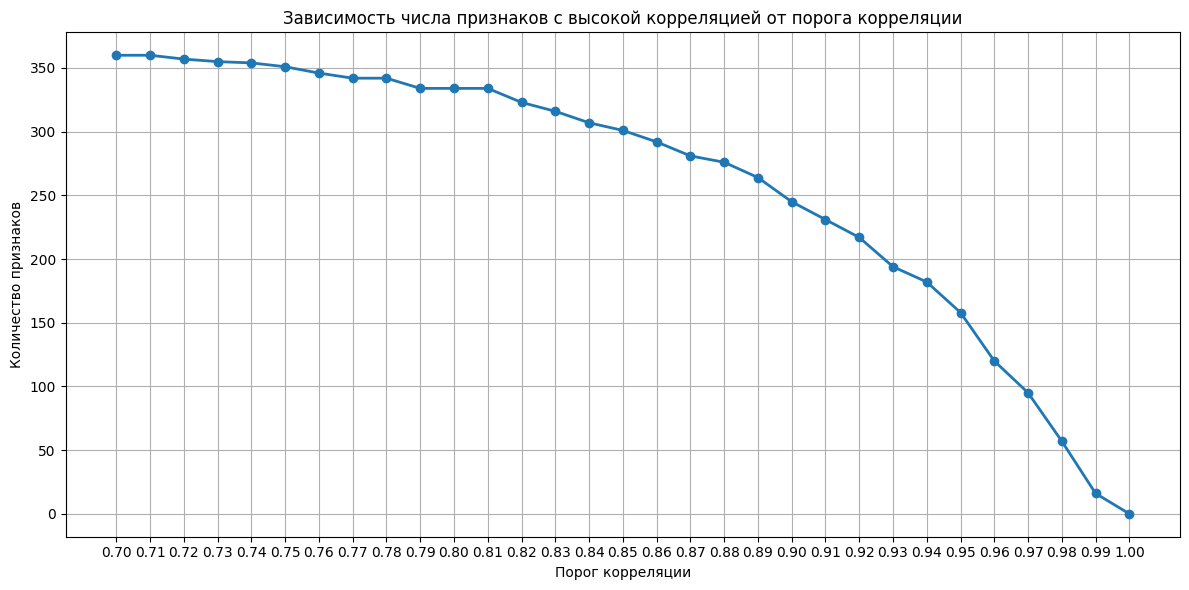

In [25]:
# Построим график зависимости числа признаков с высокой корреляцией от порога корреляции
thresholds = np.arange(0.7, 1.0, 0.01)
feature_counts = []

for threshold in thresholds:
    # Находим признаки с корреляцией выше порога
    high_corr_count = (correlation_matrix.abs() > threshold).sum() - 1  # вычитаем 1, чтобы не учитывать корреляцию признака с самим собой
    high_corr_count = high_corr_count[high_corr_count > 0]
    # Добавляем количество признаков с высокой корреляцией
    feature_counts.append(len(high_corr_count))

plt.figure(figsize=(12, 6))
plt.plot(thresholds, feature_counts, marker='o', linestyle='-', linewidth=2)
plt.title('Зависимость числа признаков с высокой корреляцией от порога корреляции')
plt.xlabel('Порог корреляции')
plt.ylabel('Количество признаков')
plt.grid(True)
plt.xticks(thresholds)
plt.tight_layout()
plt.show()


Кажется, что значение 0.85 приемлемо, т.к. это высокая корреляция и при этом число коррелирующих равно 301, что дает хорошие шансы на значительное сокращение числа признаков после анализа.

In [26]:
# Находим признаки с корреляцией выше порога
THRESHOLD_CORRELATION = 0.85
high_corr = (correlation_matrix.abs() > THRESHOLD_CORRELATION).sum() - 1  # вычитаем 1, чтобы не учитывать корреляцию признака с самим собой
high_corr = high_corr[high_corr > 0].sort_values(ascending=False)

# Список признаков, с которыми высокая корреляция
high_corr_features = {}
for feature in high_corr.index:
    # Находим все признаки, которые сильно коррелируют с текущим
    correlated_features = correlation_matrix[feature][correlation_matrix[feature].abs() > THRESHOLD_CORRELATION].index.tolist()
    # Удаляем сам признак из списка
    correlated_features.remove(feature)
    high_corr_features[feature] = correlated_features

# Преобразуем в Series для удобства отображения
high_corr_with_features = pd.Series(high_corr_features, index=high_corr.index)

print(f"Количество признаков с корреляцией >{THRESHOLD_CORRELATION}: {len(high_corr)}")
if len(high_corr) > 0:
    print("Топ-10 признаков с наибольшим количеством высоких корреляций:")
    print(high_corr.head(10))


Количество признаков с корреляцией >0.85: 301
Топ-10 признаков с наибольшим количеством высоких корреляций:
V50    29
V31    26
V42    25
V71    25
V92    24
V21    22
V72    22
V84    22
V57    21
V93    21
dtype: int64


#### Визуализация корреляций признаков

Количество компонент связности: 58


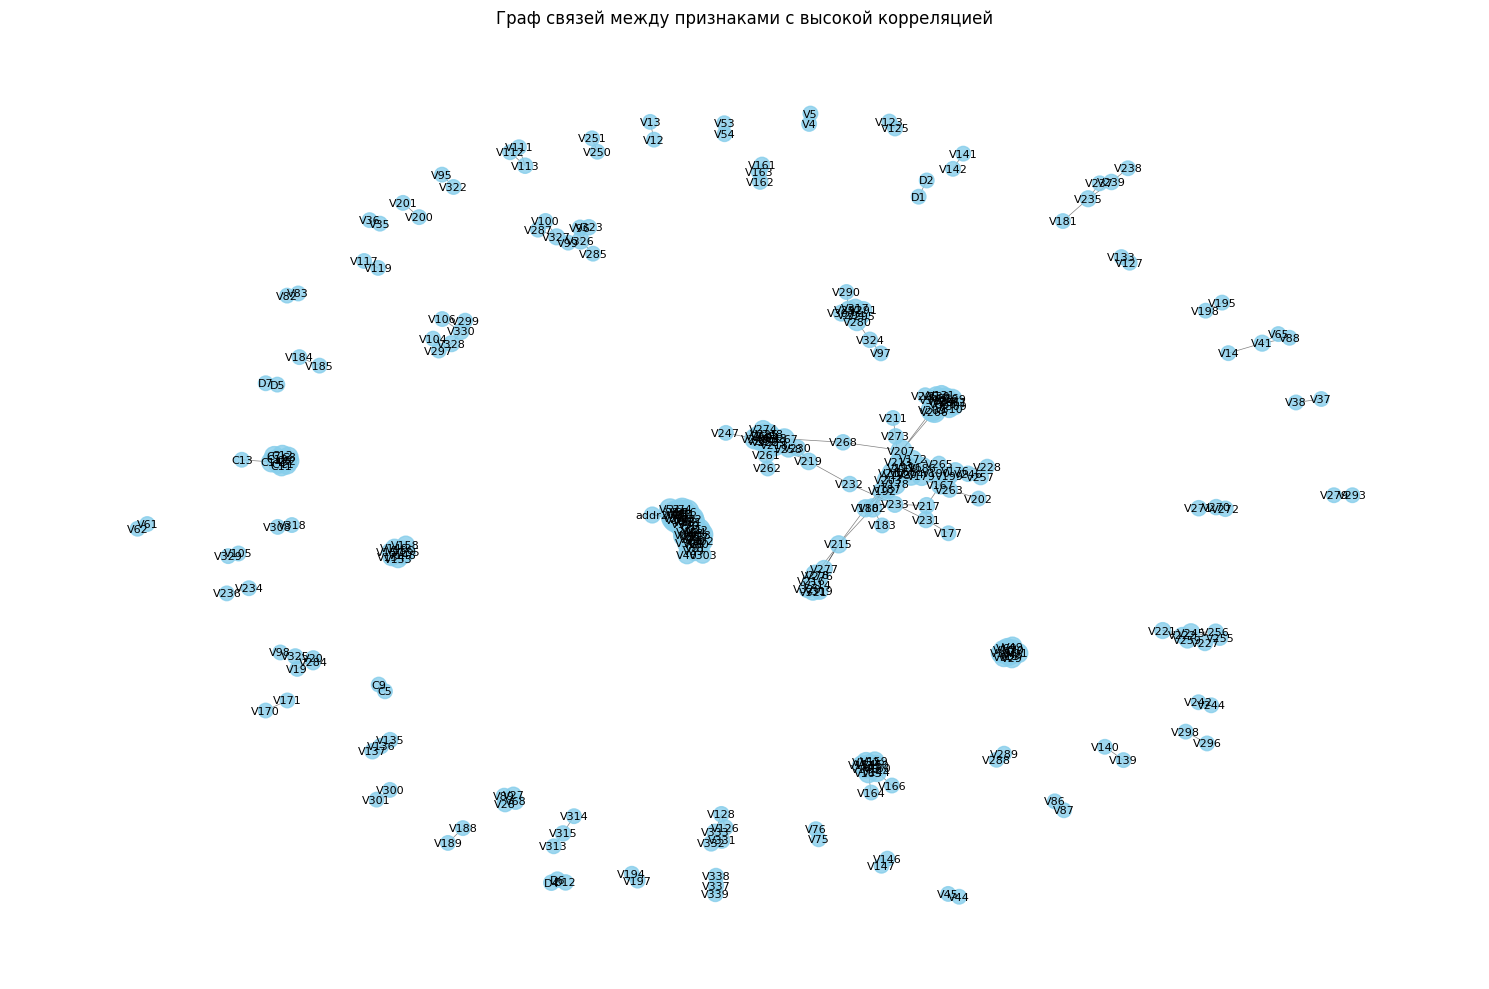

Размеры 12 крупнейших компонент связности: [77, 39, 11, 11, 10, 10, 8, 8, 7, 6, 5, 5]


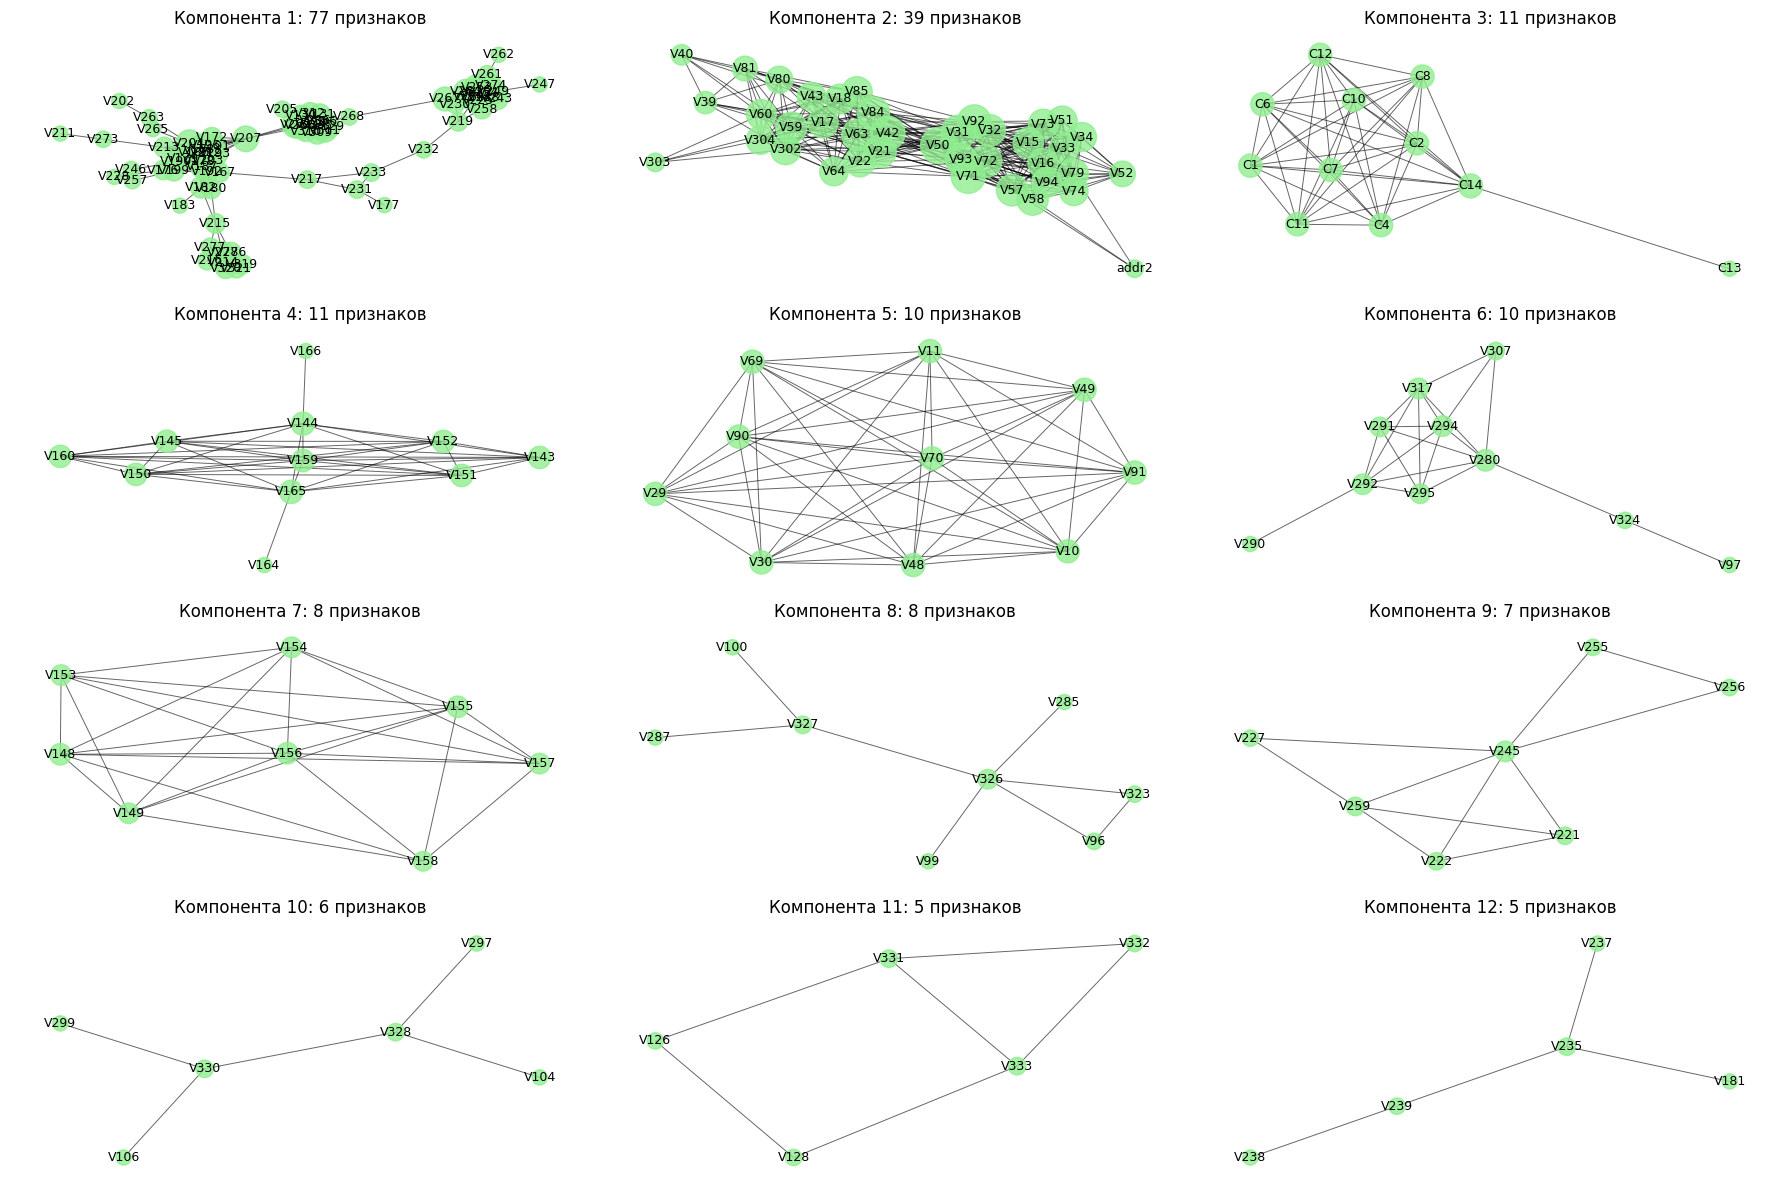

In [27]:
# Создаем граф связей между признаками
import networkx as nx
import matplotlib.pyplot as plt

# Создаем граф
G = nx.Graph()

# Добавляем узлы (признаки)
for feature in high_corr.index:
    G.add_node(feature)

# Добавляем ребра (связи между признаками с высокой корреляцией)
for feature, correlated in high_corr_features.items():
    for corr_feature in correlated:
        G.add_edge(feature, corr_feature)

# Находим компоненты связности в графе
connected_components = list(nx.connected_components(G))
print(f"Количество компонент связности: {len(connected_components)}")
# Визуализируем граф связей между признаками
plt.figure(figsize=(15, 10))

# Используем spring layout для размещения узлов
pos = nx.spring_layout(G, seed=42)

# Определяем размер узлов в зависимости от количества связей
node_size = [100 + 10 * len(high_corr_features.get(node, [])) for node in G.nodes()]

# Рисуем граф
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='skyblue', alpha=0.8)
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

plt.title('Граф связей между признаками с высокой корреляцией')
plt.axis('off')
plt.tight_layout()
plt.show()

# Визуализируем самые крупные компоненты связности
NUMBER_OF_LARGEST_COMPONENTS = 12
largest_components = sorted(connected_components, key=len, reverse=True)[:NUMBER_OF_LARGEST_COMPONENTS]
print(f"Размеры {NUMBER_OF_LARGEST_COMPONENTS} крупнейших компонент связности: {[len(comp) for comp in largest_components]}")

# Создаем подграфы для крупнейших компонент
plt.figure(figsize=(18, 12))
for i, component in enumerate(largest_components):
    if len(component) > 1:  # Визуализируем только если в компоненте больше 1 узла
        plt.subplot((NUMBER_OF_LARGEST_COMPONENTS+1)//3, 3, i+1)
        
        # Создаем подграф для компоненты
        subgraph = G.subgraph(component)
        
        # Размещаем узлы
        subpos = nx.spring_layout(subgraph, seed=i)
        
        # Определяем размер узлов
        subnode_size = [100 + 20 * len(high_corr_features.get(node, [])) for node in subgraph.nodes()]
        
        # Рисуем подграф
        nx.draw_networkx_nodes(subgraph, subpos, node_size=subnode_size, node_color='lightgreen', alpha=0.8)
        nx.draw_networkx_edges(subgraph, subpos, width=0.7, alpha=0.6)
        nx.draw_networkx_labels(subgraph, subpos, font_size=9, font_family='sans-serif')
        
        plt.title(f'Компонента {i+1}: {len(component)} признаков')
        plt.axis('off')

plt.tight_layout()
plt.show()




#### Обор признаков для удаления

**Признаки с высокой попарной корреляцией будем удалять.** 

Но из визуализации видно, что нельзя оставлять только один признак из компоненты связности, т.к. графы компонент не полносвязные, т.е. не все признаки, попавшие в компоненту, имеют высокую корреляцию со всеми другими признаками в этой же компоненте.

Удалять будем по такому правилу (можно даже не обращать внимание на компоненты связности):
1. из списка `high_corr_features` взять признак, с максимальным числом связей (т.е. попарных корреляций выше порога)
2. если есть несколько признаков с одинаковым числом связей, тогда взять тот, у которго наименьшая корреляция с целевой переменной
3. удалить этот признак (добавить его в список на удаление)
4. удалить этот признак из списков связности всех остальных признаков
5. повторять п.1 пока будут непустые списки связности.

Таким образом мы будем "вырывать" на каждой итерации самый связанный признак из графа. Иногда это будет приводить к распаду компоненты связности на несколько. В конце граф распадется на отдельные вершины без связей, т.е. не останется признаков имеющих корреляцию выше заданного порога.

In [28]:
# Формируем список признаков для удаления
features_to_remove = []

# Копируем словарь, чтобы не изменять оригинал
tmp_high_corr_features = high_corr_features.copy()


# Удаляем признаки по правилу выше
while any(len(corr_list) > 0 for corr_list in tmp_high_corr_features.values()):
    # 1. Находим признаки с максимальным числом связей
    max_connections = max(len(corr_list) for corr_list in tmp_high_corr_features.values())
    max_connected_features = [f for f, corr_list in tmp_high_corr_features.items() 
                             if len(corr_list) == max_connections]
    
    # 2. Если несколько признаков с одинаковым числом связей, выбираем с наименьшей корреляцией с целевой
    if len(max_connected_features) > 1:
        feature_to_remove = min(max_connected_features, key=lambda f: target_correlations[f])
    else:
        feature_to_remove = max_connected_features[0]
    
    # 3. Добавляем этот признак в список на удаление
    features_to_remove.append(feature_to_remove)
    
    # 4. Удаляем этот признак из списков связности всех остальных признаков
    for feature in tmp_high_corr_features:
        if feature_to_remove in tmp_high_corr_features[feature]:
            tmp_high_corr_features[feature].remove(feature_to_remove)
    
    # Удаляем сам признак из словаря
    tmp_high_corr_features.pop(feature_to_remove, None)

print(f"Количество признаков для удаления: {len(features_to_remove)}")
print("Примеры признаков для удаления:")
print(features_to_remove[:10])  # Выводим первые 10 признаков для удаления

Количество признаков для удаления: 190
Примеры признаков для удаления:
['V50', 'V31', 'V71', 'V42', 'V92', 'V59', 'V72', 'V60', 'V32', 'V266']


#### Вывод

1. Мультиколлинеарность:
   - Присутствует значительное число сильно коррелирующих признаков
   - Это может указывать на избыточность данных
   - Необходимо рассмотреть удаление части признаков для уменьшения размерности

2. Группы признаков:
   - Выделяются группы сильно коррелирующих признаков
   - Вероятно, эти группы отражают различные аспекты одних и тех же характеристик транзакций
   - Возможно создание агрегированных признаков на основе этих групп или удаление большинства признаков группы

3. Стратегия обработки:
   - Удалить сильно коррелирующие признаки, оставив по одному из каждой группы
   - При выборе между коррелирующими признаками учитывать корреляцию с целевой переменной
   - Рассмотреть создание новых признаков на основе выявленных взаимосвязей

4. Стратегия моделирования:
   - Использовать алгоритмы, устойчивые к мультиколлинеарности (деревья решений, градиентный бустинг)
   - Применить методы снижения размерности (PCA, feature selection)
   - Провести эксперименты с различными наборами признаков

#### Удалим признаки

In [31]:
# Удаляем отобранные признаки из X_train
print(f"Форма X_train до удаления признаков: {X_train.shape}")

# Удаляем признаки, которые были определены как сильно коррелирующие
X_train = X_train.drop(columns=features_to_remove)

print(f"Форма X_train после удаления признаков: {X_train.shape}")
print(f"Количество оставшихся признаков: {X_train.shape[1]}")

print(f"Форма X_test до удаления признаков: {X_test.shape}")
X_test = X_test.drop(columns=features_to_remove)
print(f"Форма X_test после удаления признаков: {X_test.shape}")


Форма X_train до удаления признаков: (417559, 431)
Форма X_train после удаления признаков: (417559, 241)
Количество оставшихся признаков: 241
Форма X_test до удаления признаков: (172981, 431)
Форма X_test после удаления признаков: (172981, 241)


In [33]:
end_mem = X_train.memory_usage().sum() / 1024**2
print('Использование памяти после удаления признаков: {:.2f} MB'.format(end_mem))
end_mem = X_test.memory_usage().sum() / 1024**2
print('Использование памяти после удаления признаков: {:.2f} MB'.format(end_mem))


Использование памяти после удаления признаков: 221.87 MB
Использование памяти после удаления признаков: 93.27 MB


# **Задание 2 (3 балла)**

Обучите несколько ML-моделей для решения поставленной задачи.
Оцените их качество двумя способами:

1) на кросс-валидации

2) на лидерборде

Подберите число фолдов на кросс-валидации так, чтобы метрики, которые вы видите, были максимально близки на кросс-валидации и на лидерборде.

По результатам экспериментов постройте таблицу:
* в каждой строке таблицы - результаты одной модели
* по столбцам: качество на кросс-валидации, качество на лидерборде, модель с гиперпараметрами
Полученную таблицу вставьте картинкой прямо в ноутбук после ячеек с кодом. Сделайте текстовые выводы.

In [ ]:
# ваши модели здесь

# **Задание 3 (2 балла)**

Попробуйте подойти к задаче как к поиску аномалий.

1) Поищите аномалии (фрод) различными рассмотренными в курсе методами и сделайте прогноз на тестовых данных.

Результатом также будет таблица:
* по строкам - методы поиска аномалий
* по столбцам - качество вашего решения на leaderboard

2) Попробуйте встроить поиск аномалий и их удаление в ML-пайплайн: найдите аномалии и что-нибудь с ними сделайте до обучения моделей (можно удалить их, а можно использовать в качестве дополнительных признаков - попробуйте разные стратегии). Результат проверьте на кросс-валидации и на лидерборде, сделайте выводы.

In [ ]:
# ваша работа с аномалиями здесь

# **Задание 4 (1 балл)**

Сделайте кластеризацию различными способами. Результаты кластеризации используйте для улучшения ML-решений:

1) Номера кластеров закодируйте (OHE или target-encoding) и добавьте как новые признаки

2) При использовании DBSCAN / HDBSCAN предсказанный шум можно трактовать как найденную аномалию и также добавить ее как новый признак

Проведите различные эксперименты. Проверьте как эти подходы влияют на качество прогнозов по кросс-валидации и на лидерборде, сделайте выводы.

In [ ]:
# ваши эксперименты с кластеризацией здесь

## **Задание 5 (1 балл)**

Примените какой-нибудь (один любой) AutoML фреймворк для решения поставленной задачи.

Отправьте AutoML-прогноз на kaggle и посмотрите на качество модели. Сделайте текстовые выводы.

In [ ]:
# ваш AutoML здесь

# **Задание 6 (1 балл)**

Весь курс мы работали в Google Colab. Но всегда должны быть запасные варианты, где Вы будете обучать модели.

Среди вариантов есть:
* ваша локальная машина
* kaggle notebooks
* yandex cloud
и другие.

Кроме привычного Google Colab выберите из списка выше один любой альтернативный вариант и проведите эксперимент:

* Прогоните ваш лучший по качеству по результатам заданий 2-4 ML-пайплайн заново в Google Colab и с помощью библиотек (например, при помощи библиотеки time) замерьте время обучения и отдельно время инференса на тестовых данных

* Прогоните этот пайплайн на выбранном альтернативном сервисе/локальной машине и также замерьте время обучения и инференса.

Текстом напишите выводы: опишите, какое альтернативное место для обучения моделей Вы использовали? Прикрепите прямо в ноутбук скриншот с экраном кода в альтернативном сервисе/на локальной машине. Также в виде таблицы приведите сравнение времени обучения и инференса в колабе и в альтернативном месте. Сделайте выводы.

In [ ]:
# ваши эксперименты здесь

# **Бонус: за Kaggle и стремление к хорошим скорам (2 балла)**

В этом домашнем задании Ваша цель - не просто выполнить шаги выше, но и построить максимально хорошую по качеству модель.

**К 10 вы можете получить до двух дополнительных баллов:**

* За попадание в топ-20% на private leaderboard — +1 дополнительный балл к оценке
* За попадание в топ-5 мест на private leaderboard — + еще один дополнительный балл к оценке (то есть суммарно 2 дополнительных балла)

**ВАЖНО!!!**

Эти баллы ставятся до мягкого дедлайна по соревнованию. После мягкого дедлайна лидерборд не обновляется, и дополнительные баллы не ставятся.

Успехов!

In [ ]:
# не забудьте прикрепить скриншоты лидерборда, пожалуйста